In [1]:
## Homework 5 Solution Template
### CSCI 4270 / 6270
### Due: April 8, 2024

Summary/Discussion

For this homework, I struggled quite a lot in figuring out how to effectively calculate the loss for the bounding box. At first, I went with masking the labels/bboxes to separate them into zero and non-zero parts. Then I tried just creating a copy of the labels and removing zero labels for bounding box calculations. In the end, the code ended up being a mixture of the two which might seem confusing to look at.

As for the results, I went through multiple learning rates. I think because of the nature of my network or because of the inputs, learning rates above 1e-5 caused exploding gradients which made the predictions result in NaNs. Therefore, I looped over a couple of learning rates each for 50 epochs and trained overnight to eventually pick 5e-5 as the learning rate and trained that for 100. The hyperparameters for the loss combination were found through observing the ratio between bbox loss and classification loss and finding a number to balance the contribution of each to the loss, which ended up just lowering the contribution of bbox loss by a lot and keeping class loss the same.

For some reason the validation loss ended up lower than the training loss when validation loss should be either higher or stabilizing at the same point as training loss. I think this might be a cause of a loss calculation error on my part or because the validation dataset generally leans more to nothing classes or the person class, making it easier to predict. We can see this through the diagonal on the confusion matrix where the number of correct predictions are significantly higher in those two classes. Another reason could probably be the size of the two datasets. The training dataset has over 23000 region images while the validation has just below 6000 regions.

For testing, I was very surprised to see my results considering I thought my training and validation results were alright. I also thought I would be able to correctly identify people since it was the most correctly identified class in training/validation. At the very least, it does seem to correctly classify each detection. It seems something went wrong somewhere and I would guess it would have to do with loss calculation for bounding boxes.

Sources/References: Charlie, Jason, Lecture Notes, StackOverflow, Pytorch docs/forums

In [2]:
import numpy as np
import json
from PIL import Image
from os.path import join

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import models
import torchvision.transforms as transforms
import torchvision.ops as ops

from functools import lru_cache
Image.open = lru_cache(6000)(Image.open)

In [3]:
"""
Implement and test the utilities in support of evaluating the results
from the region-by-region decisions and turning them into detections.

All rectangles are four component lists (or tuples) giving the upper
left and lower right cornders of an axis-aligned rectangle.  For example, 
[2, 9, 12, 18] has upper left corner (2,9) and lower right (12, 18)

The region predictions for an image for an image are stored in a list
of dictionaries, each giving the class, the activation and the
bounding rectangle.  For example,

{
    "class": 2,
    "a":  0.67,
    "rectangle": (18, 14, 50, 75)
}

if the class is 0 this means there is no detection and the rectangle
should be ignored.  The region predictions must be turned into the
detection results by filtering those with class 0 and through non
maximum supression.  The resulting regions should be considered the
"detections" for the image.

After this, detections should be compared to the ground truth 

The ground truth regions for an image are stored as a list of dictionaries. 
Each dictionary contains the region's class and bounding rectangle.
Here is an example dictionary:

{
    "class":  3,
    "rectangle": (15, 20, 56, 65)
}

Class 0 will not appear in the ground truth.  
"""

def area(rect):
    h = rect[3] - rect[1]
    w = rect[2] - rect[0]
    return h * w


def iou(rect1, rect2):
    """
    Input: two rectangles
    Output: IOU value, which should be 0 if the rectangles do not overlap.
    """ 
    x0, y0, x1, y1 = rect1
    u0, v0, u1, v1 = rect2
    ir = (max(x0, u0), max(y0, v0), min(x1, u1), min(y1, v1))
    if ir[0] >= ir[2] or ir[1] >= ir[3]:
        return 0
    else:
        return area(ir) / (area(rect1) + area(rect2) - area(ir))


def predictions_to_detections(predictions, iou_threshold=0.5):
    """
    Input: List of region predictions

    Output: List of region predictions that are considered to be
    detection results. These are ordered by activation with all class
    0 predictions eliminated, and the non-maximum suppression
    applied.
    """
    #filters class labels of 0 and sorts in descending order of activation
    nonzero_predict = [region for region in predictions if region['class'] != 0]
    nonzero_predict.sort(key=lambda x:x['a'], reverse=True)
    
    #non-max suppression (keep track of suppressed but don't remove bc suppressed can suppress others)
    keep = []
    suppressed = []
                
    for i in nonzero_predict:
        #if a suppressed region, don't keep
        if i not in suppressed:
            keep.append(i)
        for j in nonzero_predict[1:]:
            if i['class'] == j['class']:
                iou_val = iou(i['rectangle'], j['rectangle'])
                if iou_val > iou_threshold:
                    suppressed.append(j)
        
    return keep

def evaluate(detections, gt_detections, iou_threshold=0.5):
    """
    Input:
    1. The detections returned by the predictions_to_detections function
    2. The list of ground truth regions, and
    3. The IOU threshold

    The calculation must compare each detection region to the ground
    truth detection regions to determine which are correct and which
    are incorrect.  Finally, it must compute the average precision for
    up to n detections.

    Returns:
    list of correct detections,
    list of incorrect detections,
    list of ground truth regions that are missed,
    AP@n value.
    """
    #output values
    correct = []
    incorrect = []
    missed = gt_detections.copy()
    #binary vector for ap calculation
    b = []
    for pred in detections:
        same = []
        best_iou = 0
        if len(missed) != 0:
            g = missed[0]
        else:
            continue
        #finds all the gt with same label
        for gt in missed:
            if pred['class'] == gt['class']:
                same.append(gt)
        #prefiltering, if there are no gt with same label, then it is incorrect prediction      
        if len(same) == 0:
            b.append(0)
            incorrect.append(pred)
            continue
        
        #calculates iou values and finds g (gt with best iou)
        for gt in same:
            iou_val = iou(pred['rectangle'], gt['rectangle'])
            if iou_val > best_iou:
                best_iou = iou_val
                g = gt
        
        #if g is less than threshold, incorrect prediction
        if iou(pred['rectangle'], g['rectangle']) < iou_threshold:
            b.append(0)
            incorrect.append(pred)
            continue
        
        #otherwise it is a correct prediction and remove g
        b.append(1)
        correct.append(pred)
        missed.remove(g)
    
    #precision and recall pair calc
    b_np = np.array(b)
    p = np.cumsum(b_np)/np.arange(1,len(b_np)+1)
    r = np.cumsum(b_np)/len(gt_detections)
    pairs = zip(p, r)
    
    #discussed with Charlie Chen
    #calculating all p s.t r >= j/10 for each step in recall
    steps = [[],[],[],[],[],[],[],[],[],[],[]]
    for p, r in pairs:
        for j in range(11):
            if r >= j/10: steps[j].append(p) 
            else: steps[j].append(0)
    
    #calculates the max p for each step
    phat = [] 
    for step in steps:
        phat.append(max(step))
    
    #avg precision
    ap = sum(phat)/11
    return correct, incorrect, missed, ap

In [4]:
def test_iou():
    """
    Use this function for you own testing of your IOU function
    """
    # should be .370
    rect1 = (0, 5, 11, 15)
    rect2 = (2, 9, 12, 18)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0
    rect1 = (2, -3, 11, 4)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0.2
    rect1 = (3, 12, 9, 15)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

test_iou()

iou for (0, 5, 11, 15) (2, 9, 12, 18) is 0.37
iou for (2, -3, 11, 4) (2, 9, 12, 18) is 0.00
iou for (3, 12, 9, 15) (2, 9, 12, 18) is 0.20


In [5]:
def test_evaluation_code(in_json_file):
    with open(in_json_file, "r") as in_fp:
        data = json.load(in_fp)
    
    region_predictions = data["region_predictions"]
    gt_detections = data["gt_detections"]

    detections = predictions_to_detections(region_predictions)
    print(f"DETECTIONS: count = {len(detections)}")
    if len(detections) >= 2:
        print(f"DETECTIONS: first activation {detections[0]['a']:.2f}" )
        print(f"DETECTIONS: last activation {detections[-1]['a']:.2f}")
    elif len(detections) == 1:
        print(f"DETECTIONS: only activation {detections[0]['a']:.2f}")
    else:
        print(f"DETECTIONS: no activations")

    correct, incorrect, missed, ap = evaluate(detections, gt_detections)

    print(f"AP: num correct {len(correct)}")
    if len(correct) > 0:
        print(f"AP: first correct activation {correct[0]['a']:.2f}")

    print(f"AP: num incorrect {len(incorrect)}")
    if len(incorrect) > 0:
        print(f"AP: first incorrect activation {incorrect[0]['a']:.2f}")

    print(f"AP: num ground truth missed {len(missed)}")
    print(f"AP: final AP value {ap:1.3f}")


In [6]:
test_evaluation_code('eval_test1.json')

DETECTIONS: count = 2
DETECTIONS: first activation 0.90
DETECTIONS: last activation 0.70
AP: num correct 1
AP: first correct activation 0.90
AP: num incorrect 1
AP: first incorrect activation 0.70
AP: num ground truth missed 2
AP: final AP value 0.364


In [7]:
test_evaluation_code('eval_test2.json')

DETECTIONS: count = 5
DETECTIONS: first activation 0.94
DETECTIONS: last activation 0.55
AP: num correct 4
AP: first correct activation 0.90
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.655


In [8]:
test_evaluation_code('eval_test3.json')

DETECTIONS: count = 1
DETECTIONS: only activation 0.94
AP: num correct 0
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.000


In [9]:
test_evaluation_code('eval_test4.json')

DETECTIONS: count = 11
DETECTIONS: first activation 0.89
DETECTIONS: last activation 0.65
AP: num correct 10
AP: first correct activation 0.89
AP: num incorrect 1
AP: first incorrect activation 0.88
AP: num ground truth missed 1
AP: final AP value 0.835


In [10]:
'''
Skeleton model class. You will have to implement the classification and regression layers, along with the forward definition.
'''

class RCNN(nn.Module):
    def __init__(self, num_classes):
        super(RCNN, self).__init__()
        
        # Pretrained backbone. If you are on the cci machine then this will not be able to automatically download
        #  the pretrained weights. You will have to download them locally then copy them over.
        #  During the local download it should tell you where torch is downloading the weights to, then copy them to 
        #  ~/.cache/torch/checkpoints/ on the supercomputer.
        resnet = models.resnet18(pretrained=True)

        # Remove the last fc layer of the pretrained network.
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Freeze backbone weights. 
        for param in self.backbone.parameters():
            param.requires_grad = False

        # TODO: Implement the fully connected layers for classification and regression.
        self.num_classes = num_classes

        self.classification_layer = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes+1),
        )
        
        self.regression_layer = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4*num_classes),
        )
        
    def forward(self, x):
        # TODO: Implement forward. Should return a (batch_size x num_classes) tensor for classification
        #           and a (batch_size x num_classes x 4) tensor for the bounding box regression. 
        ...
        features = self.backbone(x)
        features = torch.flatten(features, 1)
        classification_output = self.classification_layer(features)
        regression_output = self.regression_layer(features)
        
        return classification_output, regression_output

In [11]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


# Dictionaries mapping class labels to names.
LABELS_TO_NAMES = {0: 'nothing',
                   1: 'bicycle',
                   2: 'car',
                   3: 'motorbike',
                   4: 'person',}


LABELS_TO_NAMES_LARGE = {0: 'nothing',
                         1: 'aeroplane',
                         2: 'bicycle',
                         3: 'bird',
                         4: 'boat',
                         5: 'bottle',
                         6: 'bus',
                         7: 'car',
                         8: 'cat',
                         9: 'chair',
                         10: 'cow',
                         11: 'diningtable',
                         12: 'dog',
                         13: 'horse',
                         14: 'motorbike',
                         15: 'person',
                         16: 'pottedplant',
                         17: 'sheep',
                         18: 'sofa',
                         19: 'train',
                         20: 'tvmonitor'}


class HW5Dataset(Dataset):
    '''
    Dataset for Train and Validation.
    Input:
        data_root - path to either the train or valid image directories
        json_file - path to either train.json or valid.json
    Output:
        candidate_region - 3 x M x M tensor
        ground_truth_bbox - 1 x 4 tensor
        ground_truth_class
    '''
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root
        self.candidate_region_size = candidate_region_size

        self.images = []
        self.candidate_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_classes = torch.empty(0, dtype=int)
        for key, values in data_dict.items():
            for val in values:
                self.images.append(key)
                self.candidate_bboxes = torch.cat((self.candidate_bboxes, torch.tensor(val['bbox']).unsqueeze(0)))
                self.ground_truth_bboxes = torch.cat((self.ground_truth_bboxes, torch.tensor(val['gt_bbox']).unsqueeze(0)))
                self.ground_truth_classes = torch.cat((self.ground_truth_classes, torch.tensor(val['class']).unsqueeze(0)))

        # Transform to convert to tensor, resize, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        
        image = Image.open(image_path)

        # Crop the image to the candidate region.
        candidate_bbox = self.candidate_bboxes[idx, :]
        candidate_region = image.crop((candidate_bbox[0].item(), candidate_bbox[1].item(), candidate_bbox[2].item(), candidate_bbox[3].item()))
        
        width, height = candidate_region.size
        x_scale = self.candidate_region_size / width
        y_scale = self.candidate_region_size / height

        # Transform to resize, convert to tensor, and normalize.
        candidate_region = self.transform(candidate_region)
        
        # Resize ground truth bounding box.
        gt_bbox = self.ground_truth_bboxes[idx, :]
        resized_gt_x0 = (gt_bbox[0] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y0 = (gt_bbox[1] - candidate_bbox[1]) * y_scale / self.candidate_region_size
        resized_gt_x1 = (gt_bbox[2] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y1 = (gt_bbox[3] - candidate_bbox[1]) * y_scale / self.candidate_region_size
        
        resized_gt_bbox = torch.tensor([resized_gt_x0, resized_gt_y0, resized_gt_x1, resized_gt_y1])
        
        return candidate_region, resized_gt_bbox, self.ground_truth_classes[idx]


class HW5DatasetTest(Dataset):
    """
    Dataset for Test.
    Input:
        data_root - path to the test image directory
        json_file - path to test.json
    Returns:
        image - numpy array A x B x 3 (RGB)
        candidate_regions - NUM_CANDIDATE_REGIONS x 3 x M x M tensor
        candidate_bboxes - all candidate bounding boxes for an image 
        ground_truth_bboxes - all ground truth bounding boxes for an image
        ground_truth_classes - all ground truth classes for an image
    """
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root

        self.images = []
        self.candidate_bboxes = []
        self.ground_truth_bboxes = []
        self.ground_truth_classes = []
        for key, values in data_dict.items():
            self.images.append(key)
            bboxes = torch.empty((len(values['candidate_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['candidate_bboxes']):
                bboxes[i, :] = torch.tensor(bbox)
            self.candidate_bboxes.append(bboxes)

            labels = torch.empty((len(values['gt_bboxes'])), dtype=int)
            bboxes = torch.empty((len(values['gt_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['gt_bboxes']):
                bboxes[i, :] = torch.tensor(bbox['bbox'])
                labels[i] = bbox['class']
            self.ground_truth_bboxes.append(bboxes)
            self.ground_truth_classes.append(labels)

        self.candidate_region_size = candidate_region_size

        # Transform to resize, convert to tensor, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        image = Image.open(image_path)

        # Apply transform to resize and normalize the candidate images.
        idx_candidate_bboxes = self.candidate_bboxes[idx]
        candidate_regions = torch.empty((len(idx_candidate_bboxes), 3, self.candidate_region_size, self.candidate_region_size))
        for i, bbox in enumerate(idx_candidate_bboxes):
            candidate_region = image.crop((bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()))
            candidate_region = self.transform(candidate_region)
            candidate_regions[i] = candidate_region

        return np.array(image), candidate_regions, self.candidate_bboxes[idx], self.ground_truth_bboxes[idx], self.ground_truth_classes[idx]


In [12]:
# Form training dataset
train_dataset = HW5Dataset("hw5_data_2024/train", "hw5_data_2024/train.json")
valid_dataset = HW5Dataset("hw5_data_2024/valid", "hw5_data_2024/valid.json")

The validation dataset has 5714 regions
After the shuffle the 4212th region has class index 0
Image shape is (224, 224, 3)


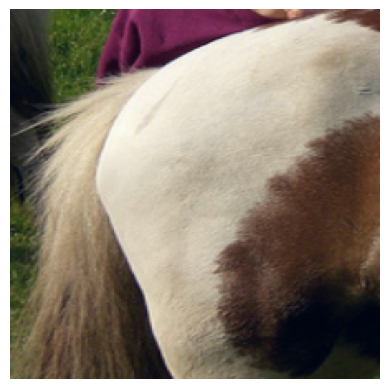

In [13]:
import random
import matplotlib.pyplot as plt

# Find and output the number of regions
n = len(valid_dataset)
print(f'The validation dataset has {n} regions')

# Randomly shuffle the region indices
indices = list(range(n))
random.shuffle(indices)

# Get the region and the class id of the random region after the shuffle.
region, gt_bbox, gt_class = valid_dataset[indices[0]]
print(f'After the shuffle the {indices[0]}th region has class index {gt_class}')

# Convert the region from an array back to a numpy 3d array
region_np = region.numpy().transpose((1, 2, 0))
print(f'Image shape is {region_np.shape}')

# Before displaying the region rescale the intensities to be between 0 and 1
region_min = region_np.min()
region_max = region_np.max()
region_np = (region_np - region_min) / (region_max - region_min)

#Display the image
plt.imshow(region_np)
plt.axis('off')
plt.show()

In [14]:
from torch.utils.data import DataLoader
#creating dataloaders for train,valid,test
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

print()
#ensuring dimensions and output types (region tensor, gt bbox, class label)
print("minibatches of 4-dimensional tensors of size Bx3x224x224")
for X,y,z in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {z.dtype}")
    print(f"Shape of z: {z.shape} {z.dtype}")
    break
    
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print()

#creating NN model and ensuring final layer outputs match what we want
num_classes = len(LABELS_TO_NAMES) - 1
model = RCNN(num_classes).to(device)
print(model)
for p in model.parameters():
    print(p.size())
    
print()
mb = torch.rand(batch_size, 3, 244, 244).to(device)
# c, r = model.forward(mb)
# # c = [batch_size, num_classes], r = [batch_size, 4*(num_classes-1)] (exclude zero class)
# print(c.size())
# print(r.size())


minibatches of 4-dimensional tensors of size Bx3x224x224
Shape of X [N, C, H, W]: torch.Size([32, 3, 224, 224])
Shape of y: torch.Size([32, 4]) torch.int64
Shape of z: torch.Size([32]) torch.int64
Using cuda device



D:\Anaconda\envs\CompVision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\CompVision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [15]:
'''Get the corresponding bbox from 4C predicted bbox according to given labels, in case of 0 label, set all val the same'''
def getBoundingBox(pred_bbox, gt_bbox, gt_label):
    #creates the desired indices based on ground truth label
    #adds another dim (all labels in its own row), gt label tensor becomes (32, 1)
    gt_label_expanded = gt_label.unsqueeze(1)
    
    #based on gt label, we find the 4 indices of the corresponding predicted bbox (32, 4). gt 0 results in negative so we 
    #clamp them to 0
    correct_bbox_indices = torch.clamp((gt_label_expanded - 1) * 4 + torch.arange(4).to(device), min=0)
    #print(correct_bbox_indices)

    #just to make the tensor size match predicted bbox size (32, 16)
    correct_bbox_indices = correct_bbox_indices.repeat(1,4)
    
    #then finds the bbox values based on the indices, then extracts the first 4 anyway since it repeats
    #print(pred_bbox)
    correct_bbox = torch.gather(pred_bbox, 1, correct_bbox_indices)
    correct_bbox = correct_bbox[:, :4]
    #print(correct_bbox)

    return correct_bbox


def train(dataloader, model, class_loss_fn, bbox_loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    training_loss = 0.0
    #for confusion matrix
    predicted_labels = []
    true_labels = []
    for batch, (X, y, z) in enumerate(dataloader):
        #region input, ground truth bbox, ground truth label
        X, y, z = X.to(device), y.to(device), z.to(device)
        
        '''Compute prediction loss'''
        pred_class, pred_bbox = model(X)
        
        #class loss straight forward, bbox loss is next...
        class_loss = class_loss_fn(pred_class, z)
        correct_bbox = getBoundingBox(pred_bbox, y, z)
        #compares first element in each row to others in same row, returns true in row if all are equal 
        #(finds when gt labels are 0)
        mask = torch.all(correct_bbox == correct_bbox[:, :1], dim=1)

        #sets to gt values (we don't want to consider ground truth classes of 0 in loss calculation)
        #works bc bbox loss function is (correct_bbox - y)^2, result is bbox loss of 0 added to total loss
        correct_bbox[mask] = y[mask]
        bbox_loss = bbox_loss_fn(correct_bbox, y)
        #print(bbox_loss)
        
        '''Backpropagation'''
        optimizer.zero_grad()
        class_loss.backward()
        bbox_loss.backward()
        optimizer.step()
        
        #hyperparams
        #alpha, beta = 1, 1e-4
        training_loss += class_loss.item() + bbox_loss.item()
        
        #for confusion matrix
        predicted_labels.extend(pred_class.argmax(1).cpu())
        true_labels.extend(z.cpu())

    training_loss /= len(dataloader)
    return training_loss, predicted_labels, true_labels

def validate(dataloader, model, class_loss_fn, bbox_loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    valid_loss, correct, avg_iou, iou_total = 0, 0, 0, 0
    #for confusion matrix
    predicted_labels = []
    true_labels = []
    #so that we do not compute gradients, only model performance
    with torch.no_grad():
        for X, y, z in dataloader:
            #region input, ground truth bbox, ground truth label
            X, y, z = X.to(device), y.to(device), z.to(device)
            pred_class, pred_bbox = model(X)
            
            #loss calc    
            correct_bbox = getBoundingBox(pred_bbox, y, z)
            mask = torch.all(correct_bbox == correct_bbox[:, :1], dim=1)
            
            #bboxes for later accuracy calculation
            for_accuracy = correct_bbox.clone().detach()
            
            #same as training
            correct_bbox[mask] = y[mask]
            #hyperparams
            #alpha, beta = 1, 1e-4
            valid_loss += class_loss_fn(pred_class, z).item() + bbox_loss_fn(correct_bbox, y).item()
            
            #accuracy check
            #if gt label is not 0 and iou of gt bbox and predicted bbox is > 0.5 and predicted class == gt label
            #this time, set bboxes corresponding to label 0 to 0
            for_accuracy[mask] = 0
            
            correct_mask = (pred_class.argmax(1) == z).type(torch.float)
            not_nothing_mask = (z != 0).type(torch.float)
            iou_boxes = ops.box_iou(for_accuracy, y)
            iou_suff = torch.where(iou_boxes > 0.5, torch.tensor(1), torch.tensor(0))
            correct += (correct_mask * not_nothing_mask * iou_suff).type(torch.float).sum().item()
            
            #for avg iou
            avg_iou += (correct_mask * not_nothing_mask * iou_boxes).sum().item()
            iou_total += (correct_mask * not_nothing_mask).sum().item()
            
            #if gt label is 0, then just check if highest activation value corresponds to gt label
            #gets all gt labels that are 0, and predicted classes that correspond to gt label 0
            mask = torch.all(z.unsqueeze(1) != 0, dim=1)
            z_copy = z[z == 0]
            pred_zero_class = pred_class[~mask]
            correct += (pred_zero_class.argmax(1) == z_copy).type(torch.float).sum().item()
            
            #for confusion matrix
            predicted_labels.extend(pred_class.argmax(1).cpu())
            true_labels.extend(z.cpu())

    valid_loss /= num_batches
    correct /= size
    return correct, valid_loss, predicted_labels, true_labels, avg_iou, iou_total

In [16]:
def time_elapsed(start):
    delta = datetime.now() - start
    m, s = divmod(delta.seconds, 60)
    h, m = divmod(m, 60)
    return f'Time elapsed: {h}h {m}m {int(s)}s'

def compute_confusion_matrix(test_pairs, num_classes):
    test_pairs_np = np.array(test_pairs)
    confusion = np.bincount(test_pairs_np[:, 0] * num_classes + test_pairs_np[:, 1]).reshape(num_classes, num_classes)
    return confusion

In [17]:
#reference/source: https://saturncloud.io/blog/custom-loss-function-in-pytorch-a-comprehensive-guide/
class bbox_loss(nn.Module):
    def __init__(self):
        super(bbox_loss, self).__init__()
        
    def forward(self, pred_class, gt_class, pred_bbox, gt_bbox):
        #print(pred_bbox)
        correct = (pred_class.argmax(1) == gt_class).type(torch.float)[:, None].expand(-1, 4)
        not_nothing = (gt_class != 0).type(torch.float)[:, None].expand(-1, 4)
        loss = correct * not_nothing * ((pred_bbox-gt_bbox)**2)
        loss = torch.sum(loss)
        return loss

#loss func
class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.MSELoss()
#lr = [1e-5, 3e-5, 5e-5, 1e-6]
from datetime import datetime
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 60
best_accuracy = 0
#for the plot
train_losses = []
valid_losses = []
train_cm, valid_cm, avg_iou, total = 0, 0, 0, 0
best_model = 'best_model2.pth'
start = datetime.now()
print("Started training at:", start)
for t in range(epochs):
    training_loss, pred, true = train(train_dataloader, model, class_loss_fn, bbox_loss_fn, optimizer)
    train_pairs = np.column_stack((pred, true)).astype(int)
    train_cm += compute_confusion_matrix(train_pairs, num_classes+1)

    validation_accuracy, validation_loss, pred, true, avg_iou, total = validate(valid_dataloader, model, class_loss_fn, bbox_loss_fn)
    valid_pairs = np.column_stack((pred, true)).astype(int)
    valid_cm += compute_confusion_matrix(valid_pairs, num_classes+1)

    train_losses.append(training_loss)
    valid_losses.append(validation_loss)
    if (validation_accuracy > best_accuracy):
        best_accuracy = validation_accuracy
        #save the model 
        torch.save(model, best_model)
        print("Epoch:", t)
        print("Training Loss:", training_loss)
        print("Validation Loss:", validation_loss)
        print("Accuracy:", best_accuracy)
        print(time_elapsed(start))
        print()
print("Done!")

Started training at: 2024-04-12 00:55:04.120161
Epoch: 0
Training Loss: 1.3446362067611788
Validation Loss: 1.1784220761697553
Accuracy: 0.8085404270213511
Time elapsed: 0h 1m 33s

Epoch: 1
Training Loss: 1.1309773196107582
Validation Loss: 1.0831707699820088
Accuracy: 2.6242562128106406
Time elapsed: 0h 2m 41s

Epoch: 2
Training Loss: 1.0571694392849365
Validation Loss: 0.9789380018375606
Accuracy: 4.07980399019951
Time elapsed: 0h 3m 47s

Epoch: 3
Training Loss: 0.977769714491316
Validation Loss: 0.8786478470217478
Accuracy: 4.583129156457823
Time elapsed: 0h 4m 53s

Epoch: 4
Training Loss: 0.9091206384426285
Validation Loss: 0.8032139435738284
Accuracy: 4.811340567028352
Time elapsed: 0h 6m 1s

Epoch: 5
Training Loss: 0.8581736074043186
Validation Loss: 0.7508607128642854
Accuracy: 5.086629331466574
Time elapsed: 0h 7m 7s

Epoch: 6
Training Loss: 0.8204925149471525
Validation Loss: 0.7153846371760227
Accuracy: 5.257612880644032
Time elapsed: 0h 8m 13s

Epoch: 7
Training Loss: 0.7919

In [18]:
#reference/source: https://saturncloud.io/blog/custom-loss-function-in-pytorch-a-comprehensive-guide/
class bbox_loss(nn.Module):
    def __init__(self):
        super(bbox_loss, self).__init__()
        
    def forward(self, pred_class, gt_class, pred_bbox, gt_bbox):
        #print(pred_bbox)
        correct = (pred_class.argmax(1) == gt_class).type(torch.float)[:, None].expand(-1, 4)
        not_nothing = (gt_class != 0).type(torch.float)[:, None].expand(-1, 4)
        loss = correct * not_nothing * ((pred_bbox-gt_bbox)**2)
        loss = torch.sum(loss)
        return loss

#loss func
class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.MSELoss()
#lr = [1e-5, 3e-5, 5e-5, 1e-6]
from datetime import datetime
optimizer = torch.optim.SGD(model.parameters(), lr=5e-5)
epochs = 60
best_accuracy = 0
#for the plot
train_losses = []
valid_losses = []
train_cm, valid_cm, avg_iou, total = 0, 0, 0, 0
best_model = 'best_model3.pth'
start = datetime.now()
print("Started training at:", start)
for t in range(epochs):
    training_loss, pred, true = train(train_dataloader, model, class_loss_fn, bbox_loss_fn, optimizer)
    train_pairs = np.column_stack((pred, true)).astype(int)
    train_cm += compute_confusion_matrix(train_pairs, num_classes+1)

    validation_accuracy, validation_loss, pred, true, avg_iou, total = validate(valid_dataloader, model, class_loss_fn, bbox_loss_fn)
    valid_pairs = np.column_stack((pred, true)).astype(int)
    valid_cm += compute_confusion_matrix(valid_pairs, num_classes+1)

    train_losses.append(training_loss)
    valid_losses.append(validation_loss)
    if (validation_accuracy > best_accuracy):
        best_accuracy = validation_accuracy
        #save the model 
        torch.save(model, best_model)
        print("Epoch:", t)
        print("Training Loss:", training_loss)
        print("Validation Loss:", validation_loss)
        print("Accuracy:", best_accuracy)
        print(time_elapsed(start))
        print()
print("Done!")

Started training at: 2024-04-12 02:04:50.499684
Epoch: 0
Training Loss: 0.4908209753471326
Validation Loss: 1.2577994133354888
Accuracy: 3.235386769338467
Time elapsed: 0h 1m 6s

Done!


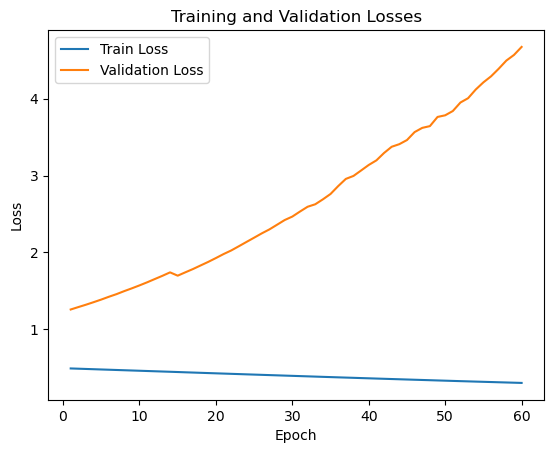


Training Confusion Matrix
 0: 568007 6096 12937 5414 35052
 1: 3136 24966 624 1639 1579
 2: 6667 2541 81715 1958 9853
 3: 2530 2601 1180 23942 2385
 4: 40300 8976 27384 10487 536971

Validation Confusion Matrix
 0: 161092 10640 23614 9015 106813
 1: 29 460  0  6 156
 2: 97  0 8309 53 3259
 3: 11  0 32 1077 99
 4: 51  0 265 229 17533



TypeError: unsupported operand type(s) for /: 'float' and 'dict'

In [24]:
'''Training and Validation Output'''
#Source: https://github.com/tensorflow/tensorflow/issues/60087
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

#summing over all should end up with the len of training dataset * # epochs (which it does), same with validation
print(f'\nTraining Confusion Matrix')
for i in range(num_classes+1):
    print(f'{i:2d}:', end='')
    for j in range(num_classes+1):
        print(f' {train_cm[i, j]:2d}', end='')
    print()
    
print(f'\nValidation Confusion Matrix')
for i in range(num_classes+1):
    print(f'{i:2d}:', end='')
    for j in range(num_classes+1):
        print(f' {valid_cm[i, j]:2d}', end='')
    print()
    
print()

print('Average IOU between predicted and correct bounding rectangles:', avg_iou/total)

In [25]:
test_dataset = HW5DatasetTest("hw5_data_2024/test", "hw5_data_2024/test.json")
test_dataloader = DataLoader(test_dataset) 

In [31]:
import cv2
def test(dataloader, model):
    mean_ap = 0
    total_correct = []
    total_incorrect = []
    total_missed = []
    output = [1, 16, 28, 30, 39, 75, 78, 88, 93, 146]
    with torch.no_grad():
        for num, (img, X, cand_bbox, gt_bbox, gt_class) in enumerate(dataloader):
            #img, region input, candidate bbox, ground truth bbox, ground truth label
            #get rid of extra dimension dataloader passes in   
            img, X, cand_bbox = img.squeeze(dim = 0).to(device), X.squeeze(dim = 0).to(device), cand_bbox.squeeze(dim = 0).to(device)
            gt_bbox, gt_class = gt_bbox.squeeze(dim = 0).to(device), gt_class.squeeze(dim = 0).to(device)
            pred_class, pred_bbox = model(X)

            #get the predicted class label and highest activation
            pred_class_label = pred_class.argmax(1)
            pred_class, _ = pred_class.max(1)
            
            #to reiterate, getBoundingBox gets all bboxes corresponding to labels, in case of 0 all bbox values are the same
            pred_bbox = getBoundingBox(pred_bbox, gt_bbox, pred_class_label)
            mask = torch.all(pred_bbox == pred_bbox[:, :1], dim=1)
            #get all bboxes, labels, activation func corresponding to predicted non-zero labels
            pred_bbox = pred_bbox[~mask]
            pred_class = pred_class[~mask]
            pred_class_label = pred_class_label[~mask]
            cand_bbox = cand_bbox[~mask].cpu().numpy()
            
            #if there exists any zero labels, just skip
            if (pred_class_label.numel() == 0):
                continue
                
            #print(pred_class_label)
            #reformat for non-max suppression
            region_predict = []
            for label, activation, box in zip(pred_class_label, pred_class, pred_bbox):
                region_predict.append({'class': label, 'a': activation, 'rectangle': box.cpu().numpy().tolist()})

            detections = predictions_to_detections(region_predict)
            
            #rescale to [0,224]
            for prediction in detections:
                prediction['rectangle'] = [val * 224 for val in prediction['rectangle']]

            #resize to original image coords
            for i in range(len(detections)):
                detections[i]['rectangle'][0] = detections[i]['rectangle'][0] + cand_bbox[i][0]
                detections[i]['rectangle'][1] = detections[i]['rectangle'][1] + cand_bbox[i][1]
                detections[i]['rectangle'][2] = detections[i]['rectangle'][2] + (cand_bbox[i][2]-cand_bbox[i][0])/224
                detections[i]['rectangle'][3] = detections[i]['rectangle'][3] + (cand_bbox[i][3]-cand_bbox[i][1])/224
            
            #reformat for evaluation between detected and ground truth
            gt_detections = []
            for label, box in zip(gt_class, gt_bbox):
                gt_detections.append({'class': label, 'rectangle': box.cpu().numpy().tolist()})
           
            correct, incorrect, missed, ap = evaluate(detections, gt_detections)
            #for final testing output
            mean_ap += ap
            total_correct.extend(correct)
            total_incorrect.extend(incorrect)
            total_missed.extend(missed)
            img = img.cpu().numpy()
            
            #testing output
            if num in output:
                print("Image", num)
                for box in correct:
                    class_label = box['class'].cpu().numpy()
                    x1, y1, x2, y2 = box['rectangle']
                    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    cv2.putText(img, str(class_label), (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                for box in incorrect:
                    class_label = box['class'].cpu().numpy()
                    x1, y1, x2, y2 = box['rectangle']
                    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
                    cv2.putText(img, str(class_label), (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

                for box in missed:
                    class_label = box['class'].cpu().numpy()
                    x1, y1, x2, y2 = box['rectangle']
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 0), 2)
                    cv2.putText(img, str(class_label), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
                out = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(out[:,:,::-1])
                plt.axis('off')
                plt.show()
                print("Average Precision:", ap)
                print()
    return mean_ap/len(dataloader), total_correct, total_incorrect, total_missed

Image 39


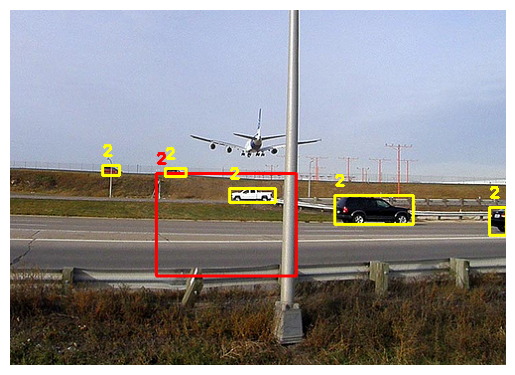

Average Precision: 0.0



In [32]:
final_model = torch.load('best_model2.pth')
final_model.eval()
mean_ap, correct, incorrect, missed = test(test_dataloader, model)

In [30]:
print("Overall mean avg precision:", mean_ap)
print()
true_pos = {1: 0, 2: 0, 3: 0, 4: 0}
total = {1: 0, 2: 0, 3: 0, 4: 0}
gt_total = {1: 0, 2: 0, 3: 0, 4: 0}
for detection in correct:
    label = int(detection['class'].cpu().numpy())
    true_pos[label] += 1
    total[label] += 1
    gt_total[label] += 1
    
for detection in incorrect:
    label = int(detection['class'].cpu().numpy())
    total[label] += 1
    
for detection in missed:
    label = int(detection['class'].cpu().numpy())
    gt_total[label] += 1
    total[label] += 1

for label in true_pos.keys():
    true = true_pos[label]/total[label] * 100
    gt_found = true_pos[label]/gt_total[label] * 100
    label_name = LABELS_TO_NAMES[label]
    print("{:<10}: {:>10.2f}% true positives, {:>10.2f}% gt detections found".format(label_name, true, gt_found))

Overall mean avg precision: 0.0

bicycle   :       0.00% true positives,       0.00% gt detections found
car       :       0.00% true positives,       0.00% gt detections found
motorbike :       0.00% true positives,       0.00% gt detections found
person    :       0.00% true positives,       0.00% gt detections found
